In [1]:
import numpy as np
import matplotlib
def addax(fig,FW,FH,L=0,W=1,T=0,H=1, ncols=1, nrows=1, wspace=0, hspace=0, width_ratios=None, height_ratios=None, sharex='none', sharey='none'):
    return fig.subplots(ncols=ncols, nrows=nrows, sharex=sharex, sharey=sharey,gridspec_kw={'wspace':wspace, 'hspace':hspace, 'width_ratios':width_ratios, 'height_ratios':height_ratios,'left':L/FW, 'right':(L+W)/FW, 'top':1-T/FH,'bottom':1-(T+H)/FH})
#%matplotlib notebook
%matplotlib inline
#import sys
#sys.path.insert(0, '../src')
#from plot import addax

import matplotlib.pyplot as plt


wire_width=12.2*10
Quarter_Wire_Circumference = wire_width*np.pi/4





In [ ]:


full_bust=84/4*10#78
over_bust=73/4*10#73
under_bust=67/4*10#67
chest_height=11*10#10.5





avg_bust = (over_bust+under_bust)/2
percentage = wire_width/avg_bust
Horizontal = wire_width+4*(full_bust-avg_bust)*percentage
Vertical = (chest_height+4*(full_bust-avg_bust))*percentage
#wire_center = (avg_bust/4)-wire_width=5.3
#Strap_off_center = wire_center*percentage/2=1.85


wire_side_half,wire_center_half = split(wire,Point(wire_bottom))

_,wire_cup_side = LineString_point_from_edge(wire_side_half,Quarter_Wire_Circumference,fromleft=False)
_,wire_cup_center = LineString_point_from_edge(wire_center_half,Quarter_Wire_Circumference,fromleft=True)


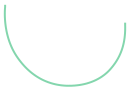

In [2]:
    
class Bezier(object):
    def __init__(self,nodes):
        import bezier
        nodes = np.asfortranarray(nodes.T)
        self.curve = bezier.Curve.from_nodes(nodes)
    def length(self):
        return self.curve.length
    def xy(self,seglength=5):
        L = self.length()
        N = max(20,int(L/seglength))
        s_vals = np.linspace(0, 1.0, N)
        xy = self.curve.evaluate_multi(s_vals)
        return xy.T
    def midpoint(self):
        from shapely.geometry import LineString
        line = LineString(self.xy())
        return np.hstack(line.interpolate(0.5, normalized = True).xy)
    
    def distance_to_points(self,points):
        from shapely.geometry import LineString
        return sum([LineString(self.xy()).distance(Point(p)) for p in points])


def segfromsvg(svg):
    from svgpathtools.path import CubicBezier
    if isinstance(svg,CubicBezier):
        points = [(svg.start.real,svg.start.imag),(svg.control1.real,svg.control1.imag),(svg.control2.real,svg.control2.imag),(svg.end.real,svg.end.imag)]
        c = Bezier(np.array(points))
        return c

def read_wire_svg(path,wire_svg_width,allowance=6):
    from svgpathtools import svg2paths
    paths, attributes = svg2paths(path)
    from shapely.geometry import LineString
    beziers,path = [],[]
    for seg in paths[0]:
        c = segfromsvg(seg)
        if c is not None:
            beziers.append(c)
            path.append(c.xy())
    xy = np.vstack(path)
    end1,end2 = xy[0]+np.array([0,-allowance]),xy[-1]+np.array([0,-allowance])
    xy = np.vstack([end1[np.newaxis,:],xy,end2[np.newaxis,:]])
    from shapely.ops import transform
    wire = transform(lambda x,y: (x,-y), LineString(xy))
    x,y = np.squeeze(np.array(wire.centroid.coords))
    from shapely import affinity
    wire = affinity.translate(wire,xoff=-x, yoff=-y)
    minx, miny, maxx, maxy = wire.bounds
    scale = wire_svg_width/(maxx-minx)
    from shapely import affinity
    wire = affinity.scale(wire, xfact=scale, yfact=scale)
    return beziers, wire

wire_svg_width = 120.9547#tip-tip horizontal distance(in mm) measured in illustrator using inner edge of wire
wirebeziers, wire = read_wire_svg('/Users/baixue/Documents/brapattern/test.svg',wire_svg_width)
wire

In [3]:
def bottom_point(line):
    from shapely.geometry import LineString
    minx, miny, maxx, maxy = line.bounds
    intersect = line.intersection(LineString([(minx,miny),(maxx,miny)]))
    return np.stack(intersect.xy).T.mean(0)

def LineString_point_from_edge(line,distance,fromleft=True):
    from shapely.ops import substring
    if fromleft:
        l = substring(line,0,distance)
        return l,np.stack(l.xy)[:,-1]
    else:
        l = substring(line,line.length-distance,line.length)
        return l,np.stack(l.xy)[:,0]


    
from shapely.geometry import LineString
from shapely.ops import split,substring
from shapely.geometry.point import Point

minx, miny, maxx, maxy = wire.bounds
intersect = wire.intersection(LineString([(minx,miny),(maxx,miny)]))
wire_bottom = np.stack(intersect.xy).T.mean(0)
wire_center = np.stack(wire.xy)[:,-1]
wire_side = np.stack(wire.xy)[:,0]

wireline_side, wireline_center = split(wire,Point(wire_bottom))
wireline_side_L,p_side = LineString_point_from_edge(wireline_side,Quarter_Wire_Circumference,fromleft=False)
wireline_side_S,p = LineString_point_from_edge(wireline_side,wireline_side.length-Quarter_Wire_Circumference,fromleft=True)
wireline_center_L,p_center = LineString_point_from_edge(wireline_center,Quarter_Wire_Circumference,fromleft=True)
#wireline_center_S,p = LineString_point_from_edge(wireline_center,wireline_center.length-Quarter_Wire_Circumference,fromleft=False)



In [4]:
def frame(wire_bottom,wire_center,wire_side,over_bust=73,under_bust=67,chest_height=11,half_wire_spacing=16):
    over_bust=over_bust/4*10
    under_bust=under_bust/4*10
    chest_height=chest_height*10
    
    seam_center_bottom = np.array([wire_center[0]+half_wire_spacing, wire_bottom[1]-12.5])
    seam_center_top = np.array([wire_center[0]+half_wire_spacing, wire_center[1]])
    seam_side_bottom = np.array([wire_center[0]+half_wire_spacing-under_bust, wire_bottom[1]-12.5])
    seam_side_overbust = np.array([wire_center[0]+half_wire_spacing-over_bust, wire_bottom[1]+chest_height])
    v = seam_side_overbust-seam_side_bottom
    seam_side_top = seam_side_bottom+v/v[1]*(wire_side[1]-seam_side_bottom[1])
    frame = np.vstack([wire_center,seam_center_top,seam_center_bottom,seam_side_bottom,seam_side_top,wire_side,])
    return frame
    


def print_pattern(xy,anchors,label,w=266.7,h=203.2,mmtoinch=0.0393701,seam_allowance=6.35):# 1/4 inch
    FW,FH = w*mmtoinch,h*mmtoinch
    fig = plt.figure(figsize=(FW,FH),dpi=100)
    
    W,H = w-1/mmtoinch,h-1/mmtoinch
    ax = addax(fig,FW,FH,L=0.5,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
    ax.set(aspect=1)
    
    ticks = [0,10,1/mmtoinch]
    ticklabels = ['start','1 cm','1 inch']
    ax.set(xlim=[0-W/2,0+W/2],ylim=[0-H/2,0+H/2],xticks=ticks,yticks=ticks,xticklabels=ticklabels,yticklabels=ticklabels)

    from shapely.geometry import Polygon
    poly = Polygon(xy)
    xy_a = np.squeeze(poly.buffer(seam_allowance, join_style=2).exterior.coords)
    centroid = np.squeeze(poly.centroid.xy)

    plt.plot(*(xy-centroid).T,'k:')
    plt.plot(*(xy_a-centroid).T,'k')
    for i,p in enumerate(anchors):
        plt.annotate(str(i), xy=(p-centroid), 
                     xytext=(p-centroid)+np.array([7,7]), textcoords='data',
                     arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)
    plt.text(0,0,label, horizontalalignment='center',verticalalignment='center')

    fig.savefig(label+'.pdf', transparent=True, rasterized=True)#
    
pattern_frame = np.vstack([np.squeeze(wire.coords), frame(wire_bottom,wire_center,wire_side)])


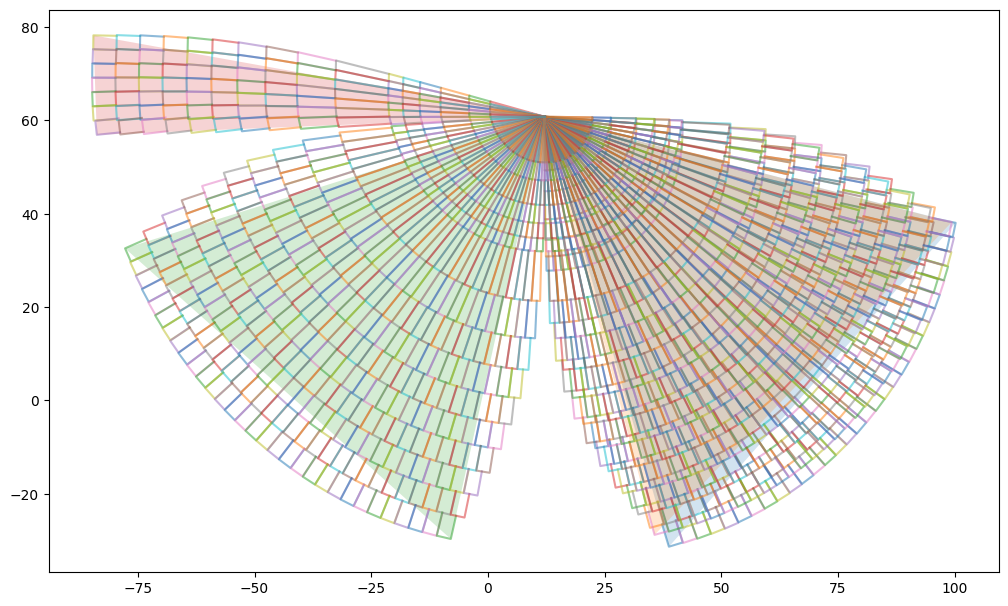

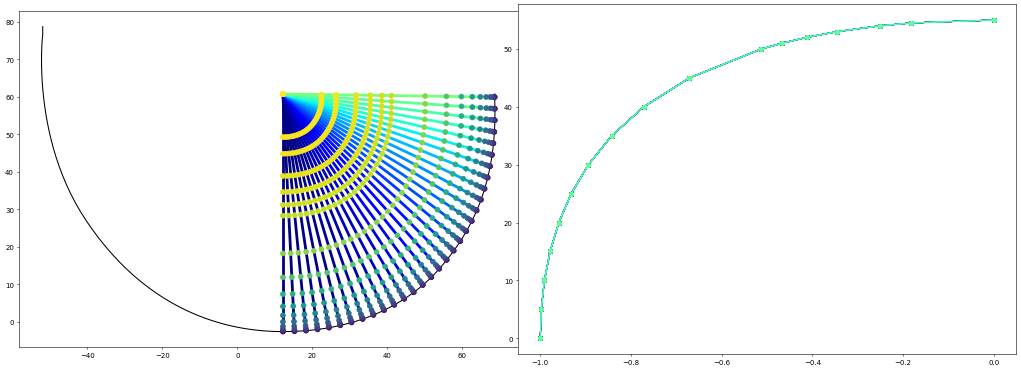

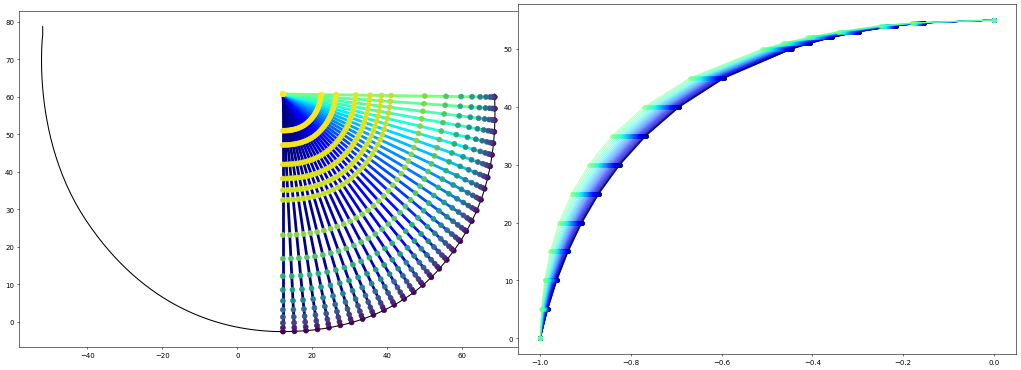

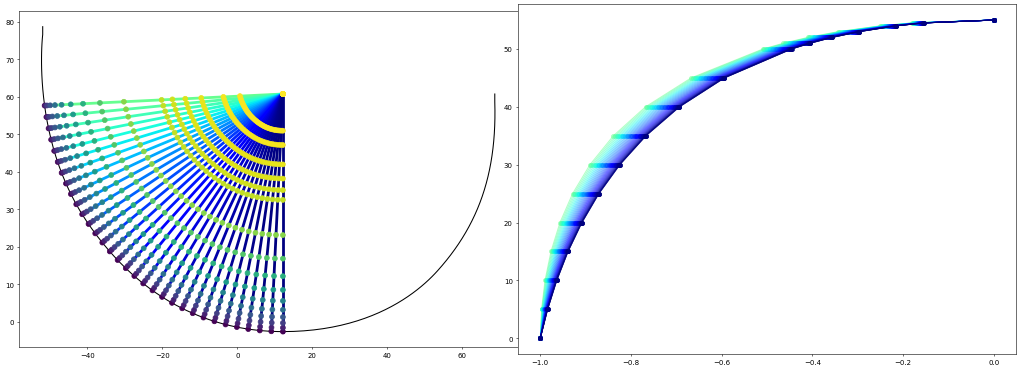

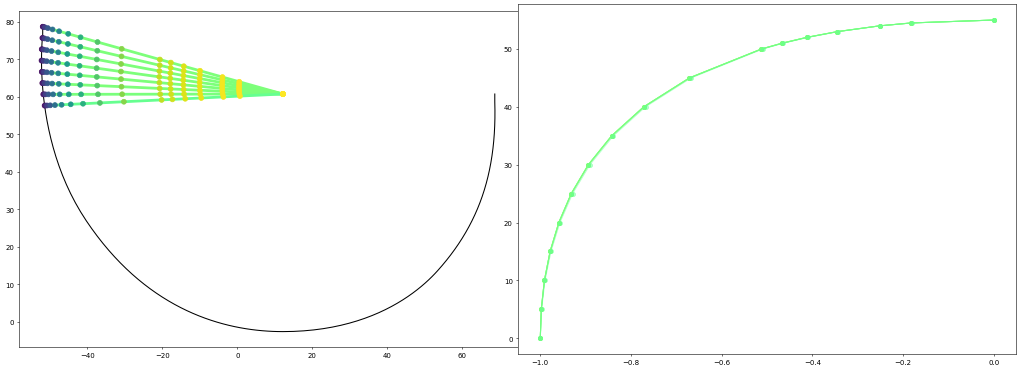

In [6]:

def point_at_given_z(b,z):
    from scipy.optimize import minimize_scalar
    fun = lambda x,b,z: abs(np.squeeze(b.curve.evaluate(x))[-1]-z)
    res = minimize_scalar(fun, method='bounded', bounds=[0,1],args=(b,z))
    #print(res)
    return np.squeeze(b.curve.evaluate(res.x))


def interpline(l,distance,normalized,fromleft=True):
    if fromleft:
        p = l.interpolate(distance, normalized=normalized)
    else:
        if normalized:
            p = l.interpolate(1-distance, normalized=normalized)
        else:
            p = l.interpolate(l.length-distance, normalized=normalized)
    return p,np.squeeze(p.xy)

    
def line_equal_divide(line,apex,ndivide):
    L = line.length
    llst = [0]+[L/ndivide]*ndivide
    pointxys,arcs = [],[]
    splitted = line
    #plt.plot(*line.xy)
    for length in np.cumsum(llst):
        point,pointxy = interpline(line,length,False)
        #plt.plot(*pointxy,'ko',ms=20,alpha=0.2)
        pointxys.append(point)
        if length>0 and abs(length-L)>1:
            cutline = LineString([apex,apex+(pointxy-apex)*1.1])
            #plt.plot(*cutline.xy,'k',alpha=0.5)
            result = split(splitted,cutline)
            arcs.append(np.squeeze(result[0].xy).T)
            splitted = result[1]
    arcs.append(np.squeeze(splitted.xy).T)
    return {'anchors':np.stack(pointxys),'arcs':arcs}
        

def proj_of_u_on_v(u,v):
    return (np.dot(u, v)/norm(v)**2)*v

def rotate_2d(theta,vec):#use radians
    c, s = np.cos(theta), np.sin(theta)
    rot_mat = np.array(((c, -s), (s, c)))
    return np.dot(rot_mat,vec)

def angle(v1, v2):
    cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos, -1.0, 1.0))
    return angle
    
def align_linestring(l,p0,q0,p1,q1):
        translate = p0-p1
        theta = angle(q0-p0,q1-p1)
        testq = Point(q1)
        testq = affinity.translate(testq, *translate)
        testq = affinity.rotate(testq, theta, origin=Point(p0), use_radians=True)
        testq = np.squeeze(testq.coords)
        if norm(testq-q0)>0.1:
            theta = -theta
        l = affinity.translate(l, *translate)
        lr = affinity.rotate(l, theta, origin=Point(p0), use_radians=True)
        return lr

class Quad(object):
    def __init__(self,A0,B0,A1,B1):
        self.points3d = np.stack([A1,A0,B0,B1])
        from numpy.linalg import norm
        theta_A0 = angle(A1-A0,B0-A0)
        from scipy.spatial.transform import Rotation as R
        r = R.from_rotvec(theta_A0 * np.array([0, 0, 1]))
        v = B0-A0
        v = v/norm(v)
        rv = r.apply(v)
        A2 = A0+rv*norm(A1-A0)

        theta_B0 = angle(A1-B0,B1-B0)
        r = R.from_rotvec(-theta_B0 * np.array([0, 0, 1]))
        v = A2-B0
        v = v/norm(v)
        rv = r.apply(v)
        B2 = B0+rv*norm(B1-B0)
        self.points2d = np.stack([A2[:2],A0[:2],B0[:2],B2[:2]])
    def align(self,quad1, share_indexes_0, share_indexes_1):
        # change coordinates of quad1 to align with self at given indexes
        quad0 = self
        p0,q0 = quad0.points2d[np.array(share_indexes_0)]
        p1,q1 = quad1.points2d[np.array(share_indexes_1)]
        l = LineString(quad1.points2d)
        lr = align_linestring(l,p0,q0,p1,q1)
        quad1.points2d = np.squeeze(lr.coords)
    def snap_center(self,other):
        pself = self.points2d[np.array([0,3])]
        pother = other.points2d[np.array([1,2])]
        vself = np.squeeze(np.diff(pself,axis=0))
        normalv = rotate_2d(np.radians(-90),vself)
        proj = proj_of_u_on_v(pother.mean(0)-pself.mean(0),normalv)
        self.points2d += proj
    def snap_left(self,other):
        pself = self.points2d[:2]
        pother = other.points2d[2:]
        vself = np.squeeze(np.diff(pself,axis=0))
        normalv = rotate_2d(np.radians(-90),vself)
        proj = proj_of_u_on_v(pother.mean(0)-pself.mean(0),normalv)
        #plt.plot(*np.stack([pself.mean(0),pself.mean(0)+proj]).T,'-')
        self.points2d += proj
    def snap_right(self,other):
        pself = self.points2d[2:]
        pother = other.points2d[:2]
        vself = np.squeeze(np.diff(pself,axis=0))
        normalv = rotate_2d(np.radians(-90),vself)
        proj = proj_of_u_on_v(pother.mean(0)-pself.mean(0),normalv)
        #plt.plot(*np.stack([pself.mean(0),pself.mean(0)+proj]).T,'-')
        self.points2d += proj
    def rotate_left(self,other,tip):
        rotate = angle(self.points2d[:2].mean(0)-tip,other.points2d[2:].mean(0)-tip)
        l = affinity.rotate(LineString(self.points2d), -rotate, origin=Point(tip), use_radians=True)
        self.points2d = np.squeeze(l.coords)
    def rotate_right(self,other,tip):
        rotate = angle(self.points2d[2:].mean(0)-tip,other.points2d[:2].mean(0)-tip)
        l = affinity.rotate(LineString(self.points2d), rotate, origin=Point(tip), use_radians=True)
        self.points2d = np.squeeze(l.coords)


def align_quarts(quads,I):
    IMAX,JMAX = quads.shape
    J = np.arange(JMAX)#np.flip()
    for i in I[:-1]:
        for j in np.flip(J)[1:]:
            quads[i%IMAX,(j+1)%JMAX].align(quads[i%IMAX,j], [1,2], [0,3])

    TIP = quads[I[0],-1].points2d[0]
    I_half_length = int(np.floor(len(I)/2))
    ICENTER = I[I_half_length]
    for di in range(I_half_length):
        for j in np.flip(J)[1:]:
            quads[(ICENTER-di-1)%IMAX,j].rotate_right(quads[(ICENTER-di)%IMAX,j],TIP)
            quads[(ICENTER-di-1)%IMAX,j].snap_center(quads[(ICENTER-di-1)%IMAX,j+1])
            quads[(ICENTER-di-1)%IMAX,j].snap_right(quads[(ICENTER-di)%IMAX,j])
            
            quads[(ICENTER+di+1)%IMAX,j].rotate_left(quads[(ICENTER+di)%IMAX,j],TIP)
            quads[(ICENTER+di+1)%IMAX,j].snap_center(quads[(ICENTER+di+1)%IMAX,j+1])
            quads[(ICENTER+di+1)%IMAX,j].snap_left(quads[(ICENTER+di)%IMAX,j])
            

from shapely.geometry.point import Point
from shapely.geometry import LineString, Polygon
from shapely.ops import split
from shapely import affinity
from numpy.linalg import norm


def visualize(arr,colors,w=266.7,h=203.2,mmtoinch=0.0393701):
    FW,FH = w*mmtoinch,h*mmtoinch
    fig = plt.figure(figsize=(FW*2.1,FH),dpi=50)
    
    W,H = w-1/mmtoinch,h-1/mmtoinch
    axes = addax(fig,FW,FH,L=0.5,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=2,nrows=1)
    axes[0].set(aspect=1)
    

    axes[0].plot(*wire.xy,'k')
        
    arr2 = arr.reshape(-1, arr.shape[-1])
    axes[0].scatter(arr2[:,0],arr2[:,1],c=arr2[:,2],s=50,alpha=1,zorder=10)


    import matplotlib.cm
    colornorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    m = matplotlib.cm.ScalarMappable(norm=colornorm,cmap='jet')
    for i in range(arr.shape[0]):
        color = colors[i]
        c = np.array(m.to_rgba(color))
        r = norm(arr[i,:,:2]-apex,axis=-1)
        r = r/(r[-1]-r[0])
        axes[0].plot(arr[i,:,0],arr[i,:,1],'-',color=c[:3],lw=4)
        axes[1].plot(r, arr[i,:,2],'o-',color=c[:3],alpha=0.5)
        
    #xy = np.squeeze(Point(apex).buffer(norm(apex-wire_center)).exterior.coords)  
    #axes[0].plot(*xy.T,'r')
    #xy = np.squeeze(Point(apex).buffer(norm(apex-wire_side)).exterior.coords)  
    #axes[0].plot(*xy.T,'r')




#def visualize(quads,w=266.7,h=203.2,mmtoinch=0.0393701):
w=266.7;h=203.2;mmtoinch=0.0393701
FW,FH = w*mmtoinch,h*mmtoinch
fig = plt.figure(figsize=(FW,FH),dpi=100)

W,H = w-1/mmtoinch,h-1/mmtoinch
ax = addax(fig,FW,FH,L=0.5,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
ax.set(aspect=1)
def fun_length(x,control_point_displacement_vector,bezier_points,target):
    p,c,q = bezier_points
    cnew = c+x*control_point_displacement_vector
    b = Bezier(np.vstack([p,cnew,q]))
    return abs(b.length()-target)

def fun_points(x,control_point_displacement_vector,bezier_points,target):
    p,c,q = bezier_points
    cnew = c+x*control_point_displacement_vector
    b = Bezier(np.vstack([p,cnew,q]))
    return b.distance_to_points(target)

def perpendicular_vector(P,Q,curve_ratio):
    C = np.squeeze(LineString([P,Q]).interpolate(curve_ratio, normalized=True).coords)
    from shapely.geometry.point import Point    
    PR = affinity.rotate(Point(P), 90, origin=Point(C), use_radians=False)
    PR = np.squeeze(PR.coords)
    U = PR-C
    U = U/norm(U)
    return C,U

def fit_bezier_points(bezier_points,U,target):
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(fun_points, method='bounded', bounds=[1,100], args=(U,bezier_points,target))
    c = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*U,bezier_points[2]]))
    return c.xy()

def fit_bezier_length(bezier_points,U,target):
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(fun_length, method='bounded', bounds=[1,100], args=(U,bezier_points,target))
    c = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*U,bezier_points[2]]))
    return c.xy()


def mirrorImage( P, Q, xys): 
    a = Q[1] - P[1]
    b = P[0] - Q[0]
    c = -(a*(P[0]) + b*(P[1]))
    mxys = np.zeros(xys.shape)
    for i,(x,y) in enumerate(xys):
        temp = -2 * (a * x + b * y + c) /(a * a + b * b)
        mxys[i] = (temp * a + x, temp * b + y) 
    return mxys



def side_profile(anchor, apex, zs, amp):
    U = anchor-apex# unit vector from apex to anchor
    U = U/norm(U)
    
    modifier = min(0,U[1])
    CTL_xy = anchor.copy()+U*amp*modifier
    apex_depth = np.max(zs)
    b = Bezier(np.vstack([(*apex,apex_depth), (*CTL_xy,apex_depth), (*anchor,0)]))
    return np.stack([(*point_at_given_z(b,z),modifier) for z in zs])

#------------------------ construct cup contour in 2d and subdivide into 9 sections ---------------------------

#cup_top = apex+np.array([0,1*norm(apex-wire_bottom)])#wire_center+np.array([-76.2,+63.5])#measured using right angle ruler
#cup = np.vstack([np.stack(wire.xy).T,Bezier(np.vstack([wire_center,cup_top,wire_side])).xy(),wire_side,])
#wireline = LineString(cup)
#wire_bottom, wireline_top = split(wire,Point(wire_center))

wire_top_center = np.array([wire_bottom[0],wire_center[1]])
#v = wire_top_center-wire_bottom
apex = wire_top_center#+v/norm(v)*10
apex_depth, step_depth = 55, 5
zs = list(np.arange(0,apex_depth,step_depth))+list(np.arange(apex_depth-step_depth+1,apex_depth,1))+[apex_depth-0.5,apex_depth]
    

leaves = {}
for name,wireseg,amp in [('tophalf',wireline_center_L,0),('center',wireline_center_L,10),('side',wireline_side_L,10),('side_S',wireline_side_S,10)]:#,('bottom_center',wireline_bottom_center),('top',wireline_top)
    ndivide = int(wireseg.length/3)
    leaves[name] = line_equal_divide(wireseg,apex,ndivide)
    temp = np.stack([side_profile(anchor, apex, zs, amp) for anchor in leaves[name]['anchors']])
    points3d, colors = [a for a in np.split(temp,[3],axis=-1)]
    visualize(points3d,np.squeeze(colors[:,0]))
    
    IMAX,JMAX = points3d.shape[:2]
    quads = np.array([[Quad(points3d[i,j],points3d[(i+1)%IMAX,j],points3d[i,j+1],points3d[(i+1)%IMAX,j+1]) for j in range(JMAX-1)]  for i in range(IMAX-1)])
    align_quarts(quads,np.arange(IMAX-1))
    
    leaves[name]['PAB'] = quads[0,-1].points2d[0],quads[0,0].points2d[1],quads[-1,0].points2d[2]
    
    ax.fill(*np.stack(leaves[name]['PAB']).T,alpha=0.2)
    for i in range(IMAX-1):
        for j in range(JMAX-1):
            ax.plot(*quads[i,j].points2d.T,alpha=0.5)
    




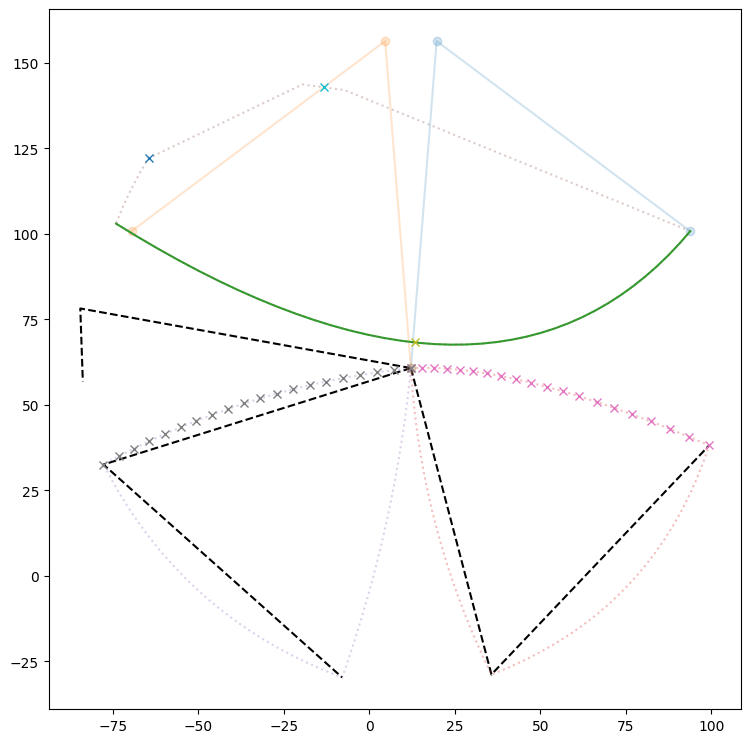

In [7]:

#def visualize(quads,w=266.7,h=203.2,mmtoinch=0.0393701):
w=266.7;h=203.2;mmtoinch=0.0393701
FW,FH = w*mmtoinch,h*mmtoinch
fig = plt.figure(figsize=(FW,FH),dpi=100)

W,H = w-1/mmtoinch,h-1/mmtoinch
ax = addax(fig,FW,FH,L=0.5,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
ax.set(aspect=1)

for name in ['center','side','side_S']:#leaves.keys():
    ax.plot(*np.stack(leaves[name]['PAB']).T,'k--')
def round_triangle(P,A,B,L,offsetA,offsetB):
    C,U = perpendicular_vector(A,B,0.5)
    ab = fit_bezier_length([A,C,B],U,L)

    C,U = perpendicular_vector(P,A,offsetA[0])
    pa = fit_bezier_points([P,C,A],U,[C+U*norm(P-A)*offsetA[1]])

    C,U = perpendicular_vector(B,P,offsetB[0])
    bp = fit_bezier_points([B,C,P],U,[C+U*norm(B-P)*offsetB[1]])
    
    return [pa,ab,bp]
    
    
def top(P,A,B,ssP,ssA,ssB,offsetB,offsetmB,L_horizontal_seam,strapwidth=12.5):
    leaf = {}
    theta = np.arcsin(15/norm(A-P))
    mpab = mirrorImage(P,A,np.stack([P,A,B]))
    mP,mA,mB = np.squeeze(affinity.rotate(LineString(mpab), -theta, origin=Point(P), use_radians=True).coords)
    theta = angle((A+mA)/2-P,np.array([0,-1]))    
    P,A,B,mP,mA,mB = np.squeeze(affinity.rotate(LineString(np.stack([P,A,B,mP,mA,mB])), -theta, origin=Point(P), use_radians=True).coords)
    P,A,B,mP,mA,mB = mirrorImage(P,P+np.array([1,0]),np.stack([P,A,B,mP,mA,mB]))
    leaf['PAB'] = [P,A,B,mP,mA,mB]
        
    
    plt.plot(*np.stack([P,A,B]).T,'o-',alpha=0.2)
    plt.plot(*np.stack([mP,mA,mB]).T,'o-',alpha=0.2)
    
    C,U = perpendicular_vector(ssA,ssB,0.5)
    ssab = fit_bezier_length([ssA,C,ssB],U,wireline_side_S.length)
    theta = angle(ssB-ssP, mB-mP)
    ssab = np.squeeze(affinity.rotate(LineString(ssab), -theta, origin=Point(ssP), use_radians=True).coords)
    #plt.plot(*ssab.T)
    
    #plt.plot(*B,'x')
    #plt.plot(*ssab[-1],'x')
    #C,U = perpendicular_vector(B,P,offsetB[0])
    #mC,mU = perpendicular_vector(P,mB,offsetmB[0])
    #target = [C+U*norm(P-B)*offsetB[1],mC+mU*norm(P-mB)*offsetmB[1]]
    bC,bU = perpendicular_vector(ssab[-1],B,0.67)
    #bb = fit_bezier_points([ssab[-1],bC,B],bU,target)
    bb = fit_bezier_length([ssab[-1],bC,B],bU,sum(L_horizontal_seam))
    bb_apex = np.squeeze(LineString(bb).interpolate(L_horizontal_seam[0],normalized=False).coords)
    plt.plot(*bb.T)

    
    C,U = perpendicular_vector(B, ssab[0], 0.7)
    l0 = LineString([mB,mA,A,B])
    l1 = LineString([C,C+U*100])
    #plt.plot(*l0.xy)
    #plt.plot(*l1.xy)
    intersect = np.squeeze(l0.intersection(l1).xy)
    leaf['markers'] = [bb_apex,intersect,ssab[0]]
    v = ssab[0]-B
    v = v/norm(v)*strapwidth/2
    strap = np.stack([intersect-v,intersect+v])
    #bb2 = fit_bezier_points([ssab[0],C,B],U,[intersect])#np.flipud(bb2)
    
    leaf['curves'] = [bb,strap,ssab]#
    return leaf
    
    

    

leaves['center']['curves'] = round_triangle(*leaves['center']['PAB'],wireline_center_L.length,(0.5,0.05),(0.67,0.05))

leaves['side']['curves'] = round_triangle(*leaves['side']['PAB'],wireline_side_L.length,(0.5,0.05),(0.5,0.03))


L_horizontal_seam = [LineString(leaves['side']['curves'][0]).length, LineString(leaves['center']['curves'][2]).length]

leaves['top'] = top(*leaves['tophalf']['PAB'],*leaves['side_S']['PAB'],(0.66,0.05), (0.5,0.03), L_horizontal_seam)



for name in ['center','side','top']:
    plt.plot(*np.vstack(leaves[name]['curves']).T,':',alpha=0.3)
    #for l in leaves[name]['curves']:
    #    print(name,LineString(l).length)
plt.plot(*leaves['center']['curves'][-1].T,'x')
plt.plot(*leaves['side']['curves'][0].T,'x')
for p in leaves['top']['markers']:
    plt.plot(*p,'x')



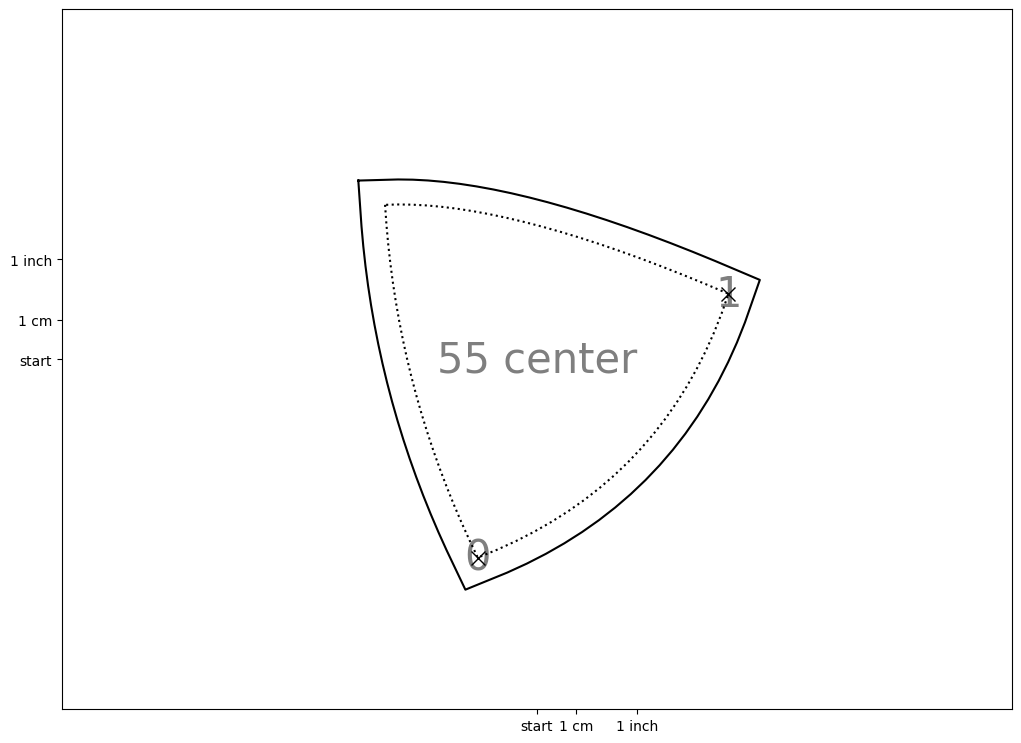

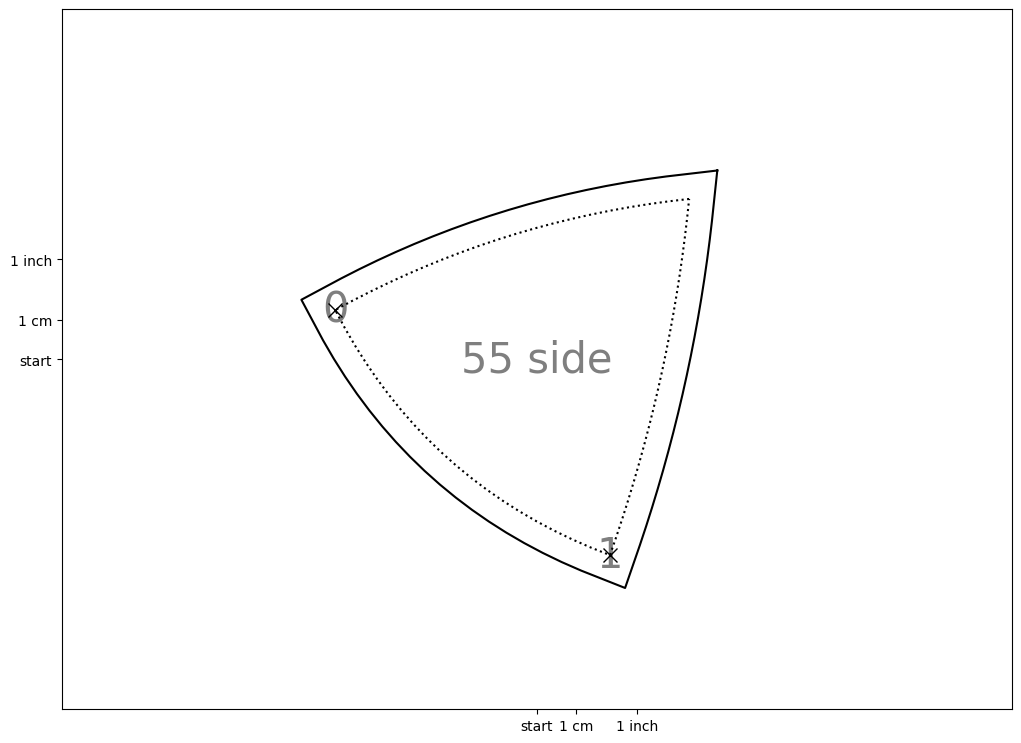

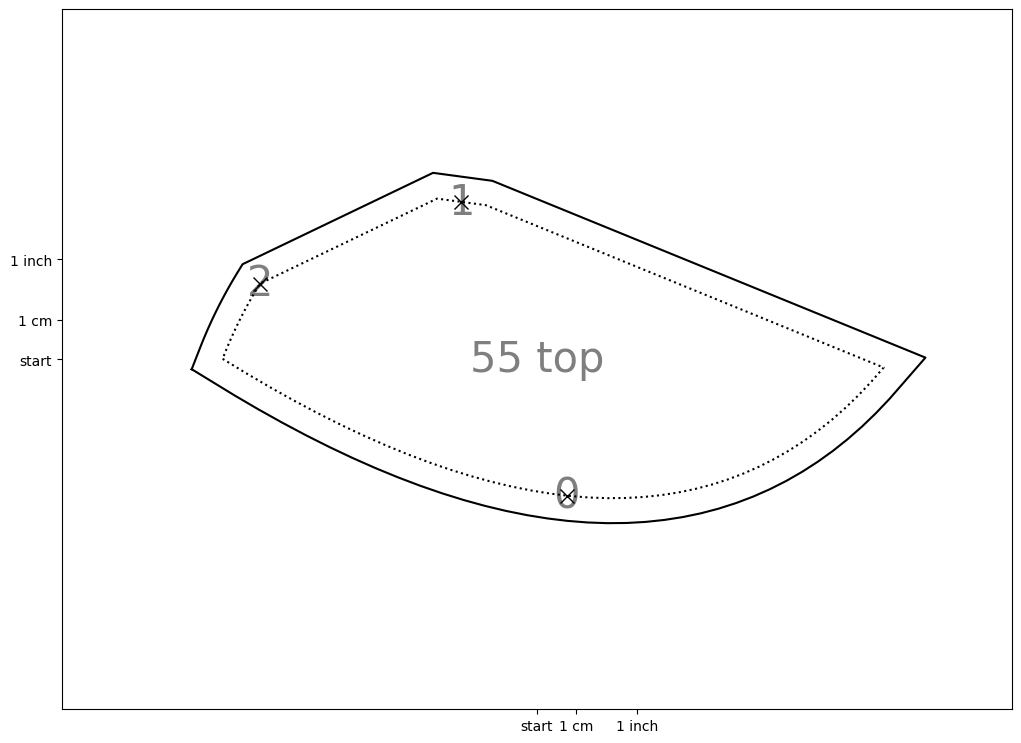

In [8]:
def print_pattern(xy,anchors,label,w=266.7,h=203.2,mmtoinch=0.0393701,seam_allowance=6.35):# 1/4 inch
    FW,FH = w*mmtoinch,h*mmtoinch
    fig = plt.figure(figsize=(FW,FH),dpi=100)
    
    W,H = w-1/mmtoinch,h-1/mmtoinch
    ax = addax(fig,FW,FH,L=0.5,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
    ax.set(aspect=1)
    
    ticks = [0,10,1/mmtoinch]
    ticklabels = ['start','1 cm','1 inch']
    ax.set(xlim=[0-W/2,0+W/2],ylim=[0-H/2,0+H/2],xticks=ticks,yticks=ticks,xticklabels=ticklabels,yticklabels=ticklabels)

    from shapely.geometry import Polygon
    poly = Polygon(xy)
    xy_a = np.squeeze(poly.buffer(seam_allowance, join_style=2).exterior.coords)
    centroid = np.squeeze(poly.centroid.xy)

    plt.plot(*(xy-centroid).T,'k:')
    plt.plot(*(xy_a-centroid).T,'k')
    for i,p in enumerate(anchors):
        plt.plot(*(p-centroid),'kx',ms=10)
        plt.text(*(p-centroid),str(i), horizontalalignment='center',verticalalignment='center',fontsize=30,alpha=0.5)
    plt.text(0,0,label, horizontalalignment='center',verticalalignment='center',fontsize=30,alpha=0.5)

    #fig.savefig(label+'.pdf', transparent=True, rasterized=True)#
    return fig
    
patterns = []
#patterns.append((pattern_frame,[wire_bottom,p_side,p_center],'frame'))
for name in ['center','side']:
    patterns.append((np.vstack(leaves[name]['curves']),leaves[name]['PAB'][1:],name))
patterns.append((np.vstack(leaves['top']['curves']),leaves['top']['markers'],'top'))
    
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(str(apex_depth)+'.pdf') as pdf:
    for xy,anchors,name in patterns:
        fig = print_pattern(xy,anchors,str(apex_depth)+' '+name)
        pdf.savefig(transparent=True, rasterized=True)

In [36]:
wire_width=12.2*10
Quarter_Wire_Circumference = wire_width*3.14/4

xy = np.squeeze(Point(wire_bottom).buffer(wire_width/2).exterior.coords)+np.array([0,wire_width/2])


In [ ]:

wire_anchors = np.vstack([p_bottom_side[:-1],p_bottom_center[:-1],p_top[:-1]])

arcs = arc_bottom_side+arc_bottom_center+arc_top
#plt.plot(*wire_anchors.T,'rx',alpha=0.5)
#plt.plot(*wireline.xy,'k',alpha=0.3)

#print(len(p_bottom_side), len(arc_bottom_side))
#print(len(p_bottom_center), len(arc_bottom_center))
#print(len(p_top), len(arc_top))
#print(len(wire_anchors),len(arcs))

#------------------------ find iso-depth points on radial lines from apex to each cup section ---------------------------
bezier_control_xylenghth = 1.5*np.mean([LineString([apex,p]).length for p in wire_anchors])# larger multiplies generates more full and less pointy shape
sinlst = []
P = (*apex,apex_depth)
arr = np.zeros((len(wire_anchors),len(zs),3))
for i,p in enumerate(wire_anchors):#
    Q = (*p,0)
    v = p-apex
    sin = bezier_control_depth(apex,p)
    CTL_xy = p+v/norm(v)*(10*sin)#interpline(LineString([apex,p]), bezier_control_xylenghth, False)[1]# contorl point
    CTL_z = apex_depth#
    CTL = (*CTL_xy,CTL_z)
    b = Bezier(np.vstack([P,CTL,Q]))
    for j,z in enumerate(zs):
        arr[i][j] = point_at_given_z(b,z)
    sinlst.append(sin)

def bezier_control_depth(apex,p):
    v = p-apex
    v = v/norm(v)
    #print(v[1])
    if v[1]<-0:
        return v[1]
    else:
        return 0




In [64]:
    
#steep = (norm(arr[:,:,:2]-apex,axis=-1).mean(0), arr[:,:,2].mean(0))
#plt.plot(*steep, 'k',lw=4,alpha=0.5)

In [31]:
points3d.shape

(21, 14, 3)

In [74]:
zs

[0, 5, 10, 15, 20, 25, 30, 35, 36, 37, 38, 39, 40]

In [46]:
np.split(np.arange(arr.shape[0]),[7,14])

[array([0, 1, 2, 3, 4, 5, 6]),
 array([ 7,  8,  9, 10, 11, 12, 13]),
 array([14, 15, 16, 17, 18, 19, 20])]

In [8]:
def sidelines(quads,I):
    l = np.stack([quads[i,0].points2d[1] for i in I]+[quads[-1,0].points2d[2]])
    l0 = np.stack([quads[I[0],j].points2d[1] for j in np.arange(quads.shape[1])]+[quads[I[0],-1].points2d[0]])
    l1 = np.stack([quads[I[-1],j].points2d[2] for j in np.arange(quads.shape[1])]+[quads[I[0],-1].points2d[0]])
    return l,l0,l1



In [38]:




for name,direction,alignidx in [('side',-1,-1),('center',1,0)]:
    leaves[name] = [l+(leaves['top'][2][alignidx]-leaves[name][1][-1]) for l in leaves[name]]
    theta = angle(np.array([0,1]), np.squeeze(np.diff(leaves[name][1][-2:],axis=0)))
    leaves[name] = [np.squeeze(affinity.rotate(LineString(np.vstack(l)), direction*theta, origin=Point(leaves[name][1][-1]), use_radians=True).coords) for l in leaves[name]]


plt.plot(*np.vstack(leaves['side']).T,'c--',alpha=0.5,lw=4)
plt.plot(*np.vstack(leaves['center']).T,'r--',alpha=0.5,lw=4)


theta = angle(np.squeeze(np.diff(leaves['top'][0][:2],axis=0)),np.squeeze(np.diff(leaves['side'][2][:2],axis=0)))
top = [np.squeeze(affinity.rotate(LineString(np.vstack(l)), theta, origin=Point(leaves['top'][0][0]), use_radians=True).coords) for l in leaves['top']]

plt.plot(*np.vstack(top).T,'y--',alpha=0.5,lw=4)


theta = angle(np.squeeze(-1*np.diff(leaves['top'][1][-2:],axis=0)),np.squeeze(np.diff(leaves['center'][2][:2],axis=0)))
top = [np.squeeze(affinity.rotate(LineString(np.vstack(l)), -theta, origin=Point(leaves['top'][2][0]), use_radians=True).coords) for l in leaves['top']]

plt.plot(*np.vstack(top).T,'y--',alpha=0.5,lw=4)



0.02759212790130092

array([[-2.17326461,  4.9302738 ]])

In [211]:
LineString(l).length,wireline_bottom_center.length



(99.95136643235938, 96.64134527390294)

In [144]:
def fit_bezier(P,Q,target_type,curve_ratio,target_value):
    C = np.squeeze(LineString([P,Q]).interpolate(curve_ratio, normalized=True).coords)
    bezier_points = [P,C,Q]
    from shapely.geometry.point import Point    
    PR = affinity.rotate(Point(P), 90, origin=Point(C), use_radians=False)
    PR = np.squeeze(PR.coords)
    U = PR-C
    U = U/norm(U)
    
    from scipy.optimize import minimize_scalar
    if target_type=='offset':
        target_value = [C+U*target_value]
        res = minimize_scalar(fun_points, method='bounded', bounds=[1,100], args=(U,bezier_points,target_value))
    else:#target_type=='length'
        res = minimize_scalar(fun_length, method='bounded', bounds=[1,100], args=(U,bezier_points,target_value))
    c = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*U,bezier_points[2]]))
    #print(target,c.length())
    return c.xy()

N = 0
for name in ['bottom_side','bottom_center','top']:#leaves.keys():
    n = leaves[name]['anchors'].shape[0]-1
    I = np.arange(N,N+n)
    N += n
    align_quarts(quads,I)
    leaves[name]['l0'] = sideline0(quads,I)
    leaves[name]['l1'] = sideline1(quads,I)
    
l = leaves['bottom_center']['l1']
leaves['bottom_center']['l1'] = fit_bezier(l[0],l[-1],'points',0.5,l[-5:])

l = leaves['top']['l0']
leaves['top']['l0'] = fit_bezier(l[-1],l[0],'points',0.5,l[-5:])


for name in ['bottom_side','bottom_center','top']:
    ax.plot(*leaves[name]['l0'].T,'k')
    ax.plot(*leaves[name]['l1'].T,'k:')
    l0,l1 = leaves[name]['l0'],leaves[name]['l1']
    print(LineString(l0).length,LineString(l1).length, norm(l0[-1]-l0[0]), norm(l1[-1]-l1[0]) )



#visualize(quads)

        
        
        
        
            

l = leaves['bottom_center']['l1']
leaves['bottom_center']['l1'] = fit_bezier(l[0],l[-1],'points',0.5,l[-5:])

l = leaves['bottom_side']['l0']
leaves['bottom_side']['l0'] = fit_bezier(l[-1],l[0],'points',0.5,l[-5:])



l = leaves['top']['l0']
leaves['top']['l0'] = fit_bezier(l[-1],l[0],'length',0.6,LineString(leaves['bottom_center']['l1']).length)

l = leaves['top']['l1']
leaves['top']['l1'] = fit_bezier(l[0],l[-1],'length',0.5,LineString(leaves['bottom_side']['l0']).length)





array([[-76.72369639,  63.33785041],
       [-71.99405956,  67.32059264],
       [-67.14285523,  70.62113892],
       [-62.09726327,  73.14045143],
       [-56.66632691,  74.77289673],
       [-50.40867677,  75.39049952],
       [-42.36182072,  74.75895175],
       [-30.04035093,  72.16801267],
       [-26.46230141,  71.31474058],
       [-22.16874299,  70.2342764 ],
       [-16.74072459,  68.80783456],
       [ -9.09732056,  66.72559477],
       [ -3.28945176,  65.11379398],
       [ 12.15680496,  60.78601705]])

(-150.38950389725977, -3.779514811695087)

[ 0.93666526 66.07680669]


In [50]:
def lineFromPoints(P, Q):
 
    if(b < 0):
        print("The line passing through points P and Q is:",
              a, "x - ", b, "y = ", c, "\n")
    else:
        print("The line passing through points P and Q is: ",
              a, "x + ", b, "y = ", c, "\n")

1.5707963267948966

AttributeError: 'list' object has no attribute 'shape'

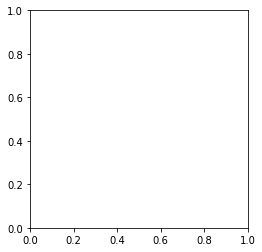

In [120]:

    flatten = [Polygon(quads[i%IMAX,j%JMAX].points2d) for j in J for i in I]
    
    A0,A1 = quads[I[0],0].points2d[1],quads[I[-1],0].points2d[2]#
    l0 = [quads[I[0],j].points2d[1] for j in J]
    
    
    wiresegfitted = fit_bezier(A1,TIP,curve_params[0][:2]+[np.stack(l0[-5:])])
    plt.plot(*wiresegfitted.T,'r')
    #wiresegfitted = fit_bezier(TIP,A0,curve_params[1])
    #plt.plot(*wiresegfitted.T,'c')
    
    #target = [np.mean(q.points2d,axis=0) for q in quads[I,0]]
    #curve_ratio = 
    wiresegfitted = fit_bezier(A0,A1,curve_params[2])#outline_wireseam

    #print(sum([norm(np.diff(q.points2d[1:3],axis=0)) for q in quads[I,0]]), wireseg.length,LineString(wiresegfitted).length)
    outline = [TIP]+list(np.flipud(l0))+list(wiresegfitted)+[quads[I[-1],j].points2d[2] for j in J]+[TIP]
    outline = np.vstack(outline)
    return flatten,outline,[A0,A1]

ax = plt.subplot(111)
ax.set(aspect=1)


IMAX,JMAX = arr.shape[:2]
quads = np.array([[Quad(arr[i,j],arr[(i+1)%IMAX,j],arr[i,j+1],arr[(i+1)%IMAX,j+1]) for j in range(arr.shape[1]-1)]  for i in range(arr.shape[0])])
    
patterns = []
#patterns.append((pattern_frame,[wire_bottom],'frame'))


info = [('bottom side',wireline_bottom_side,(['offset',0.7,5], ['offset',0.2,5], ['length',0.5,wireline_bottom_side.length])),
       ]# ('bottom center',wireline_bottom_center,([], [], 0.5)),#('top',wireline_top,([], [], 0.5))

for i,(name,wireseg,curve_ratio) in enumerate(info):
    flatten,xy,anchors = align_strips(quads,np.arange(ndivide)+ndivide*i,curve_ratio)
    for p in flatten:
        ax.plot(*np.squeeze(p.exterior.coords).T,alpha=0.2)
    ax.plot(*xy.T,'k-',alpha=0.4)
    for i,p in enumerate(anchors):
        ax.annotate(str(i), xy=p, xytext=p+np.array([10,10]), textcoords='data',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)
    patterns.append((xy,anchors,name))
    

8 (9, 9, 3) 8 8


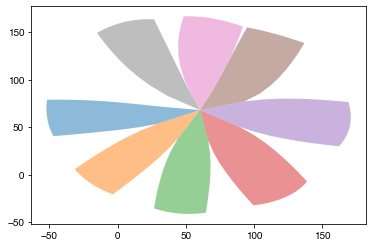

In [47]:

#j = quads.shape[1]-1
#for i in range(quads.shape[0]):
#    print(i,(i+1)%quads.shape[0])
#    quads[i,j].align(quads[(i+1)%quads.shape[0],j], [2,3], [1,0])
    #plt.plot(*quads[i,j].points2d.T,'-o',alpha=0.4)
def align_3_strips(quads,icenter,wireseg,curve_ratio):
    jrange = np.flip(np.arange(quads.shape[1]))
    i_n1 = (icenter-1)%quads.shape[0]
    i_p1 = (icenter+1)%quads.shape[0]
    tip = quads[i_n1,quads.shape[1]-1].points2d[0]
    flatten = []
    for j in jrange:
        if j<quads.shape[1]-1:
            quads[icenter,j+1].align(quads[icenter,j], [1,2], [0,3])
            quads[i_n1,j+1].align(quads[i_n1,j], [1,2], [0,3])
            quads[i_p1,j+1].align(quads[i_p1,j], [1,2], [0,3])

    
    for j in jrange:
        translate = quads[icenter,j].points2d[1] - quads[i_n1,j].points2d[2]
        quads[i_n1,j].points2d += translate
        translate = quads[icenter,j].points2d[2] - quads[i_p1,j].points2d[1]
        quads[i_p1,j].points2d += translate
    
    for j in jrange:
        for i in [i_n1,icenter,i_p1]:
            flatten.append(Polygon(quads[i,j].points2d))
    
    outline_wireseam = np.vstack([quads[i,0].points2d[1:3] for i in [i_n1,icenter,i_p1]])
    wiresegfitted = fit_bezier(quads[i_n1,0].points2d[1],quads[i_p1,0].points2d[2],outline_wireseam,curve_ratio)    
    
    outline = [tip]+[quads[i_n1,j].points2d[1] for j in jrange]+list(wiresegfitted)+[quads[i_p1,j].points2d[2] for j in np.flip(jrange)]
    outline = np.vstack(outline)
    
    print(wireseg.length,LineString(wiresegfitted).length)
    return flatten, outline, wireseg, [quads[i_n1,0].points2d[1], quads[i_p1,0].points2d[2]]






    leaf = []
    for i in [i_n1,icenter,i_p1]:
        pie = [[tip],[tip]]
        for j in jrange:
            pie[0].append(quads[i,j].points2d[1])
            pie[1].append(quads[i,j].points2d[2])
        pieoutline = np.vstack([np.vstack(pie[0]),np.flipud(np.vstack(pie[1]))])
        leaf.append(pieoutline)
    outline = np.vstack(leaf)

    #quads[icenter,j].align(quads[i_n1,j], [1,0], [2,3])
            #quads[icenter,j].align(quads[i_p1,j], [2,3], [1,0])
            
    #outline_n1 = [tip, quads[i_n1,quads.shape[1]-1].points2d[1]]
    #outline_p1 = [tip,quads[i_p1,quads.shape[1]-1].points2d[2]]
        #if j<quads.shape[1]-1:
        #    outline_n1.append(outline_n1[-1] - quads[i_n1,j].points2d[0] + quads[i_n1,j].points2d[1])
        #    outline_p1.append(outline_p1[-1] - quads[i_p1,j].points2d[3] + quads[i_p1,j].points2d[2])
    #from shapely.ops import unary_union
    #outline = np.squeeze(unary_union(flatten).buffer(10).buffer(-10).exterior.coords)

    rotate = angle(quads[i_n1,0].points2d[2]-tip,quads[icenter,0].points2d[1]-tip)
    l_n1 = LineString([tip]+[quads[i_n1,j].points2d[1] for j in jrange])
    l_n1r = affinity.rotate(l_n1, rotate/2, origin=Point(tip), use_radians=True)
    plt.plot(*np.squeeze(l_n1r.coords).T)
    
    rotate = angle(quads[i_p1,0].points2d[1]-tip,quads[icenter,0].points2d[2]-tip)
    l_p1 = LineString([tip]+[quads[i_p1,j].points2d[2] for j in jrange])
    l_p1r = affinity.rotate(l_p1, -rotate/2, origin=Point(tip), use_radians=True)
    plt.plot(*np.squeeze(l_p1r.coords).T)
    
    #outline_center = quads[icenter,0].points2d[np.array([2,1])]#outline_center,
    #outline = np.vstack([outline_wireseam,np.flipud(np.stack(outline_p1)),np.stack(outline_n1)])#wiresegfitted
    target = quads[icenter,0].points2d[1:3].mean(0)
    cutline = LineString([Point(tip),Point(target)])#affinity.translate(wireseg, )
    plt.plot(*np.squeeze(cutline.coords).T)
    intersect = np.squeeze(wireseg.intersection(cutline).xy)
    wireseg2 = affinity.translate(wireseg,*(target-intersect))
    plt.plot(*np.squeeze(wireseg2.coords).T)

    
    
        
class Quad2d(object):
    def __init__(self,points2d):
        self.points2d = points2d
    def align(self,quad1, share_indexes_0, share_indexes_1):
        # change coordinates of quad1 to align with self at given indexes
        quad0 = self
        p0,q0 = quad0.points2d[np.array(share_indexes_0)]
        p1,q1 = quad1.points2d[np.array(share_indexes_1)]
        l = LineString(quad1.points2d)
        lr = align_linestring(l,p0,q0,p1,q1)
        quad1.points2d = np.squeeze(lr.coords)

    
    
    lqs = []
    found = False
    for j in jrange:
        if j<quads.shape[1]-1 and not found:
            gap = max(norm(quads[i_n1,j].points2d[2]-quads[icenter,j].points2d[1]),norm(quads[icenter,j].points2d[2]-quads[i_p1,j].points2d[1]))
            if gap>2:
                found = True
                for i in [i_n1,icenter,i_p1]:
                    q = np.vstack([quads[i,0].points2d[1],quads[i,j].points2d[1:3],quads[i,0].points2d[2]])
                    lqs.append(Quad2d(q))
                    
    lqs[1].align(lqs[0], [1,0], [2,3])
    lqs[1].align(lqs[2], [2,3], [1,0])
    for q in lqs:
        plt.plot(*q.points2d.T)

    
    
                    
                    
                    
                    
                    
    for j in jrange:
        if j<quads.shape[1]-1:
            gap = norm(quads[i_n1,j].points2d[2]-quads[icenter,j].points2d[1])
            if gap>2:
                l = LineString(quads[icenter,j].points2d[1:3])
                intersect3 = np.squeeze(l.intersection(cutline).xy)
                wireseg3 = affinity.translate(wireseg2,*(intersect3-target))
                length = sum([norm(quads[i,j].points2d[3]-quads[i,j].points2d[1]) for i in [i_n1,icenter,i_p1]])
                print(wireseg.length/length)
                plt.plot(*np.squeeze(wireseg3.coords).T)

class Pie(object):
    def __init__(self,As,Bs,arc):
        self.poly = np.vstack([np.flipud(As),arc,Bs])
        self.split_index = [len(As),len(As)+len(arc)]
    def coords(self):
        As,arc,Bs = np.split(self.poly,self.split_index)
        return np.flipud(As),Bs,arc
        
def flattern_quad(A0,B0,A1,B1):
    from numpy.linalg import norm
    theta_A0 = angle(A1-A0,B0-A0)
    from scipy.spatial.transform import Rotation as R
    r = R.from_rotvec(theta_A0 * np.array([0, 0, 1]))
    v = B0-A0
    v = v/norm(v)
    rv = r.apply(v)
    A2 = A0+rv*norm(A1-A0)
    
    theta_B0 = angle(A1-B0,B1-B0)
    r = R.from_rotvec(-theta_B0 * np.array([0, 0, 1]))
    v = A2-B0
    v = v/norm(v)
    rv = r.apply(v)
    B2 = B0+rv*norm(B1-B0)

    #print(np.round(norm(A2-A0)),np.round(norm(B2-B0)))#np.round(norm(B0-A0)),np.round(norm(B2-A2)),
    #p = np.stack([A0,B0,A1,B1,A2,B2])#
    #plt.scatter(p[:,0],p[:,1],c=p[:,2])
    #plt.plot(B2[0],B2[1],'rx',ms=20)
    
    return A0,B0,A2,B2


def align(l,p,q,p0,q0):
    translate = p-p0
    theta = angle(q-p,q0-p0)
    testq = Point(q0)
    testq = affinity.translate(testq, *translate)
    testq = affinity.rotate(testq, theta, origin=Point(p), use_radians=True)
    testq = np.squeeze(testq.coords)
    #print(np.round(q),np.round(testq),norm(testq-q))
    if norm(testq-q)>0.1:
        theta = -theta
    l = affinity.translate(l, *translate)
    lr = affinity.rotate(l, theta, origin=Point(p), use_radians=True)
    return l,lr
   
    
pies = []
for i in range(arr.shape[0]-1):#[0,1,7,8]:#
    As,Bs = [],[]
    #plt.figure()
    for j in range(arr.shape[1]-1):
        A0,B0,A2,B2 = flattern_quad(arr[i,j],arr[i+1,j],arr[i,j+1],arr[i+1,j+1])
        if j==0:
            poly = np.stack([A2,A0,B0,B2])
            As.append(A0)
            Bs.append(B0)
        else:# traslate,rotate poly so that A0,B0 overlaps with A2,B2 at the last time point  
            A,B = poly[0],poly[-1]
            l,lr = align(LineString([A2,A0,B0,B2]),A,B,A0,B0 )
            #poly = np.squeeze(l.coords)
            #plt.plot(poly[:,0],poly[:,1],'k',alpha=0.5)
            poly = np.squeeze(lr.coords)
        #plt.plot(poly[:,0],poly[:,1],alpha=0.5)
        As.append(poly[0])
        Bs.append(poly[-1])
    As = np.stack(As)
    Bs = np.stack(Bs)
    #print(LineString(As).length,LineString(Bs).length)
    pie = Pie(As[:,:-1],Bs[:,:-1],arcs[i])
    pies.append(pie)
    
    
print(len(wire_anchors),arr.shape,len(arcs),len(pies))
    
import copy
pies_original = copy.deepcopy(pies)
    

#plt.figure()
#poly = pies[0].poly
#plt.plot(poly[:,0],poly[:,1],alpha=0.5)
idx0,idx1 = -1,-2#0,1#
for i in range(1,len(pies)):#
    prev_pie = pies[i-1]
    curr_pie = pies[i]
    prev_B = prev_pie.coords()[1]
    curr_A = curr_pie.coords()[0]
    l,lr = align(LineString(curr_pie.poly),prev_B[idx0],prev_B[idx1],curr_A[idx0],curr_A[idx1] )
    curr_pie.poly = np.squeeze(lr.xy).T
    #poly = np.squeeze(l.coords)
    #plt.plot(poly[:,0],poly[:,1],'k',alpha=0.5)
    #poly = np.squeeze(lr.coords)
    #plt.plot(poly[:,0],poly[:,1],alpha=0.5)
    
    
plt.figure()
for pie in pies:
    plt.fill(*pie.poly.T,alpha=0.5)
    As,Bs,arc = pie.coords()
    


array([60.30633989, 67.89263918])

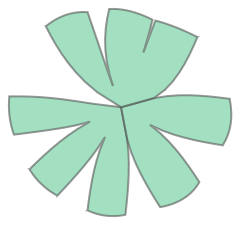

In [50]:
def fit_bezier(P,Q,wireseg,curve_ratio):
    #wirelength = wireseg.length
    wirexy = np.squeeze(wireseg.coords)
    wireseg = align_linestring(wireseg,P,Q,wirexy[0],wirexy[-1])
    wireseg = np.squeeze(wireseg.coords)
    
    C = np.squeeze(LineString([P,Q]).interpolate(curve_ratio, normalized=True).coords)
    #C = (P+Q)/2
    bezier_points = [P,C,Q]
    from shapely.geometry.point import Point    
    PR = affinity.rotate(Point(P), 90, origin=Point(C), use_radians=False)
    PR = np.squeeze(PR.coords)
    U = PR-C
    U = U/norm(U)
    #target_points = [Point(t) for t in wireseg]   
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(fun, method='bounded', bounds=[1,100], args=(U,bezier_points,wireseg))
    c = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*U,bezier_points[2]]))
    return wireseg, c.xy()

def leaf(pies):
    As = np.flipud(pies[0].coords()[0])
    Bs = pies[-1].coords()[1]
    arcs = [pie.coords()[2] for pie in pies]
    hull = LineString(np.vstack([As]+arcs+[Bs]))
    from shapely.ops import unary_union
    contour = unary_union([Polygon(pie.poly) for pie in pies]).buffer(0.1).buffer(-0.1).exterior
    gaplength = [line.length for line in hull-contour if line.length>2]
    return contour,gaplength
def centroid_at_origin(obj):
    centroid = np.squeeze(obj.centroid.xy)
    return np.squeeze(obj.xy).T-centroid

pielst = np.split(pies,[3,5])
cups = [leaf(pies)[0] for pies in pielst]#


from shapely.geometry.collection import GeometryCollection
GeometryCollection([Polygon(c) for c in cups])



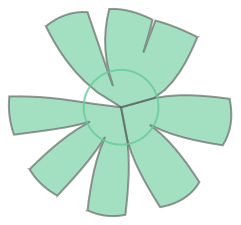

In [81]:
cutline_from_tip = np.interp(apex_depth*0.75, steep[1], steep[0])

circ = Point(pies[0].coords()[0][-1]).buffer(1)#circle of radius 1 around center point
e = affinity.scale(circ, cutline_from_tip, cutline_from_tip)
GeometryCollection([Polygon(c) for c in cups]+[e.exterior])


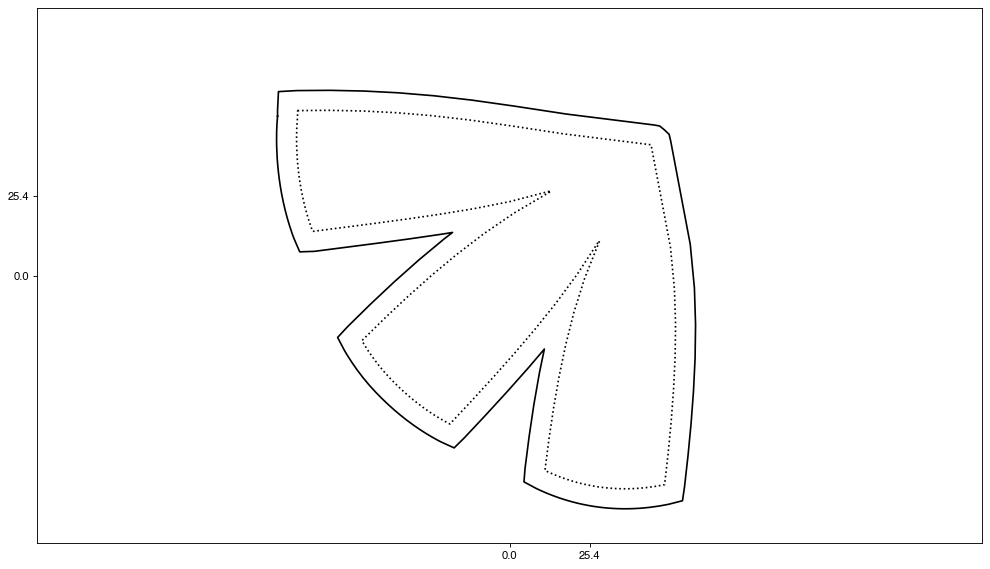

In [52]:
def centroid_at_origin(obj):
    centroid = np.squeeze(obj.centroid.xy)
    return np.squeeze(obj.xy).T-centroid



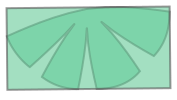

In [50]:
c = Polygon(cups[0])
rect = np.squeeze(c.minimum_rotated_rectangle.exterior.coords)
rect_vectors = np.diff(rect,axis=0)
v = rect_vectors[np.argmin(norm(rect_vectors,axis=1))]
c2 = affinity.rotate(c, -np.arccos(v[1]/norm(v)), origin='centroid', use_radians=True)

GeometryCollection([c,c.minimum_rotated_rectangle])

In [20]:
for i in np.arange(len(pies)-2):
    l = LineString(np.vstack([pie.coords()[2] for pie in pies[i:i+2]]))-leaves[0]
    print(l.length)

53.95162568634402
9.99162631878154
11.083919888438707
64.19885202992653
90.84326891072502
92.00220596043701


In [112]:
from shapely.ops import unary_union
leaf = unary_union([Polygon(pie.poly) for pie in pies[:2*N]]).buffer(1).buffer(-1)
leaf_convex = Polygon()

from shapely.ops import nearest_points
convexp = np.stack([np.squeeze(nearest_points(triangle,Point(apex))[0]) for triangle in leaf_convex-leaf if triangle.area>10])
convexp

array([[-12.08554272,  44.95985846],
       [  5.87235596,  22.95686627],
       [ 32.68632964,  12.32186959],
       [ 56.86239125,  17.02178012],
       [ 74.91082767,  34.02544455]])

In [150]:
splitted = list(split(leaf,LineString(convexp)))
split_main = splitted[0]
rectangles = splitted[1:]
i=0
target_point = Point(pies[i].coords()[1][0])
near_rect = rectangles[np.argmin([LineString(nearest_points(rect,target_point)).length for rect in rectangles])]
theta = angle(pies[i].coords()[1][0]-convexp[i], pies[i+1].coords()[0][0]-convexp[i])
near_rect2 = affinity.rotate(near_rect, -theta, origin=Point(convexp[i]), use_radians=True)


In [123]:
Point(pies[i].coords()[1][0]).xy

(array('d', [-47.1197331784476]), array('d', [40.38395101080512]))

0.3032013234550532

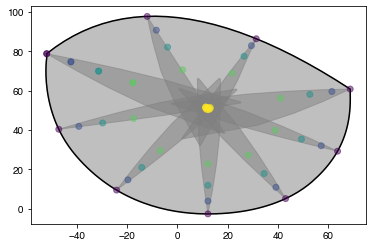

In [28]:
for pie in pies_original:
    plt.fill(*pie.poly.T,color='gray',alpha=0.5)
isop = arr.reshape(-1, arr.shape[-1])
plt.scatter(isop[:,0],isop[:,1],c=isop[:,2],alpha=0.5,zorder=10)
plt.plot(*wireline.xy,'k')


In [17]:
i,j=0,0
dc[i,j],dr[i,j]


(29.111295914590723, 22.55382797856607)

In [7]:
    
    print(B0-A0,normal_unit_vector(A0,B0),norm(A1-A0))
    B2 = B0+normal_unit_vector(B0,A2)*norm(B1-B0)
    print(norm(B2-A2),norm(B1-A1))



In [21]:
np.linalg.norm(np.diff(arr[i],axis=0),axis=1)

array([16.6588026 , 18.8010824 , 27.07246751])

In [26]:
np.linalg.norm(np.diff(arr[:,j],axis=0),axis=1)

array([6.75435008, 7.21115905, 7.57771045, 7.89008964, 8.12016462,
       8.24479597, 8.32413943])

In [40]:
def flatten_first_dimension(arr):
    return arr.reshape(-1, arr.shape[-1])

t = flatten_first_dimension(arr[:2])

In [52]:

def fun(x,b,q,L):
    s = np.squeeze(b.curve.evaluate(x))
    l = Bezier(np.vstack([s,q]))
    return abs(l.length()-L)

def point_at_given_distance(p,r,q,L):
    b = Bezier(np.vstack([p,r,q]))
    from scipy.optimize import minimize_scalar
    res = minimize_scalar(fun, method='bounded', bounds=[0,1],args=(b,q,L))
    #print(res)
    return np.squeeze(b.curve.evaluate(res.x))

ss = np.arange(0,100,10)
quad = {s:{} for s in ss}
quadp = []
    
    for s in ss:
        if s<b.length():
            quad[s][tuple(p)] = point_at_given_distance((*apex,apex_depth),(*lc,apex_depth),(*p,0),s)

quadp = []
for z in list(quad.keys()):#[:2]
    if len(quad[z])>0:
        p = np.stack(list(quad[z].values()))
        quadp.append(p)
        plt.plot(p[:,0],p[:,1],'x')
plt.plot(*wireline.xy,'k')

        
isop = []
for z in iso.keys():
    p = np.stack(list(iso[z].values()))
    isop.append(p)
    print(z,LineString(p).length)
isop = np.vstack(isop)


dict_keys([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])

<IPython.core.display.Javascript object>


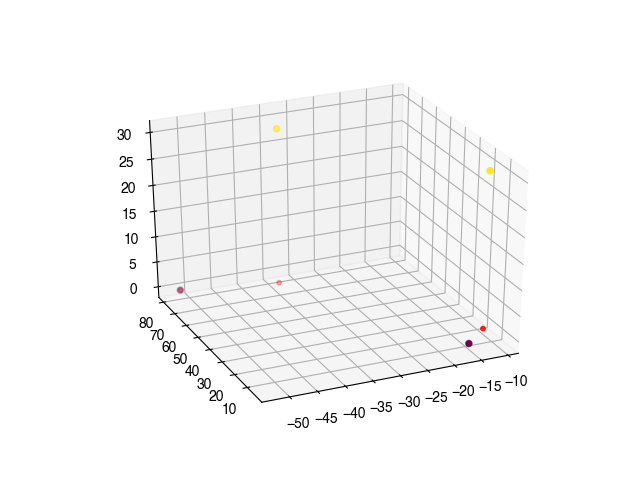

<ipython-input-9-8de3fdff486c>:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')


In [9]:

#i = 0
t = np.vstack([arr[0],np.flipud(arr[3])])



import matplotlib.pyplot as plt
import numpy as np
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
#ax.plot3D(xline, yline, zline, 'gray')

ax.scatter3D(*t.T, c=t[:,2]);
ax.scatter(t[:,0],t[:,1],c='r',s=10)




array([-44.31736799,  75.48516185,  10.00008793])

array([49, 39, 29, 19,  9])

In [9]:
#XYZ = XYZ-np.array([*apex,0])

In [19]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(XYZ)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 10 * avg_dist
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
dec_mesh = bpa_mesh

voxel_size = max(dec_mesh.get_max_bound() - dec_mesh.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = dec_mesh.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
output_path="/Users/baixue/Downloads/"
o3d.io.write_triangle_mesh(output_path+"bpa_mesh.ply", mesh_smp)





voxel_size = 3.768748e+00


True

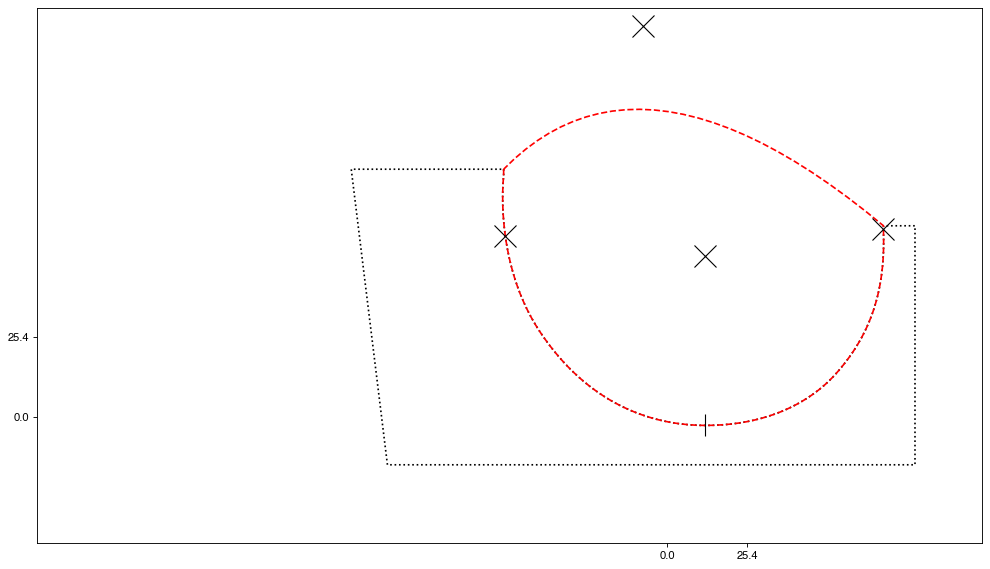

In [17]:

mmtoinch = 0.0393701
W,H = 300,170
FW,FH = W*mmtoinch+2,H*mmtoinch+2
fig = plt.figure(figsize=(FW,FH),dpi=80)
ax = addax(fig,FW,FH,L=1,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
ax.set(aspect=1)
ax.set(xlim=[100-W,100],ylim=[130-H,130],xticks=[0,1/mmtoinch],yticks=[0,1/mmtoinch])



plt.plot(*frame.T,'k:')
plt.plot(*cup.T,'r--')
#plt.plot(*frame_seam.T,'k')

plt.plot(*wire_bottom,'k|',ms=20)
plt.plot(*wire_cup_side,'kx',ms=20)
plt.plot(*wire_cup_center,'kx',ms=20)
plt.plot(*apex,'kx',ms=20)
plt.plot(*cup_top,'kx',ms=20)





fig.savefig('shape2.svg', transparent=True, rasterized=True)# 


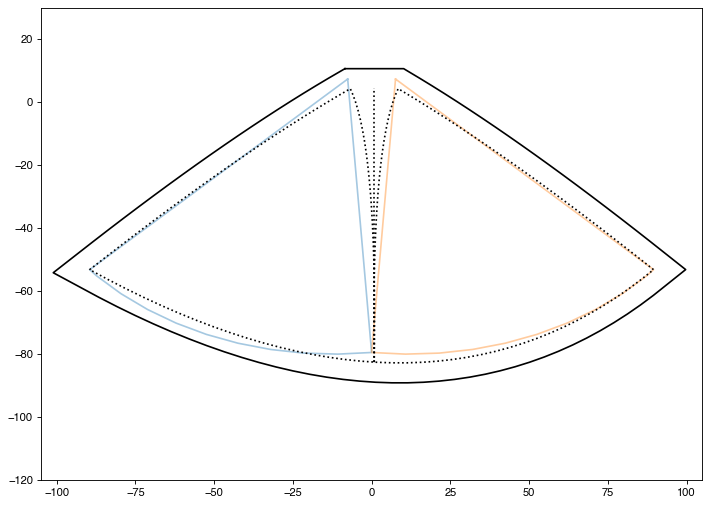

In [11]:
def unit_vector(p,q):
    v = q-p
    return np.flip(v)/np.linalg.norm(v)

def fit_curve_to_points_perpendicular_line(l,target,offset=2,ratio=0.5,bounds=[1,100]):
    from shapely.geometry import LineString
    from shapely.geometry.point import Point
    from scipy.optimize import minimize_scalar
    p,q = np.stack(l.xy).T
    r = np.stack(LineString([p,q]).interpolate(ratio, normalized=True).xy).T[0]
    u = unit_vector(p,q)
    
    target_points = []
    for t in target:
        if isinstance(t, Point):
            target_points.append(t)
        else:
            target_points.append(Point(r+u*t))
            
    bezier_points = [p,r,q]
    fun = lambda x,v,bezier_points,target_points: Bezier(np.vstack([bezier_points[0],bezier_points[1]+x*u,bezier_points[2]])).distance_to_points(target_points)
    res = minimize_scalar(fun, method='bounded', bounds=bounds,args=(u,bezier_points,target_points))
    c = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*u,bezier_points[2]]))
    return c.xy()

def draft_bottom_cup(ROTATE=5):
    from shapely.geometry import LineString
    from shapely.ops import split
    from shapely.geometry.point import Point
    from shapely import affinity
    from scipy.optimize import minimize_scalar
    circ = Point((0,0)).buffer(1)#circle of radius 1 around center point
    e  = affinity.scale(circ, Horizontal/2, Vertical/2)
    c = split(LineString(np.stack(e.exterior.xy).T),Point(bottom_point(e)))[1]
    arc,_ = LineString_point_from_edge(c,Quarter_Wire_Circumference,fromleft=True)
    
    pie = LineString(np.vstack([(0,0),arc]))
    pie = affinity.rotate(pie, ROTATE, origin=Point(np.stack(pie.xy).T[-1]))
    pie = affinity.translate(pie, xoff=-max(pie.xy[0]), yoff=0)
    piexy = np.stack(pie.xy).T
    piexy = np.vstack([piexy,piexy[0]])
    
    end_1 = np.stack(pie.xy).T[-1]
    end_2 = end_1*np.array([-1,1])#reflect at y=0
    v = end_2-end_1
    v = np.flip(v)/np.linalg.norm(v)
    
    bezier_points = [end_1,np.stack(LineString([end_1,end_2]).interpolate(0.6, normalized=True).xy).T,end_2]
    fun = lambda x,v,bezier_points,target_length: abs(Bezier(np.vstack([bezier_points[0],bezier_points[1]+x*v,bezier_points[2]])).length()-target_length)
    res = minimize_scalar(fun, method='bounded', bounds=[-100,-1],args=(v,bezier_points,2*Quarter_Wire_Circumference))
    b = Bezier(np.vstack([bezier_points[0],bezier_points[1]+res.x*v,bezier_points[2]]))
    
    wire = LineString(b.xy())
    wire_side,wire_bottom = LineString_point_from_edge(wire,Quarter_Wire_Circumference,fromleft=True)
    wire_center,_ = LineString_point_from_edge(wire,Quarter_Wire_Circumference,fromleft=False)

    apex = wire_bottom+np.array([0,Vertical/2])
    vertical = LineString(np.stack([wire_bottom,apex]))
    
    

    vertical_side = affinity.rotate(vertical, ROTATE, origin=Point(wire_bottom))
    vertical_side_c = fit_curve_to_points_perpendicular_line(vertical_side,[vertical.interpolate(0.3, normalized = True)],ratio=0.8)
    horiz_side = LineString(np.stack([end_1,np.stack(vertical_side.xy).T[-1]]))
    horiz_side_c = fit_curve_to_points_perpendicular_line(horiz_side,[5],ratio=0.5)
    side = np.vstack([vertical_side_c,np.flipud(horiz_side_c),np.stack(wire_side.xy).T])


    vertical_center = affinity.rotate(vertical, -ROTATE, origin=Point(wire_bottom))
    vertical_center_c = 2*np.array([wire_bottom[0],0])+vertical_side_c*np.array([-1,1])
    horiz_center = LineString(np.stack([np.stack(vertical_center.xy).T[-1],end_2]))
    horiz_center_c = fit_curve_to_points_perpendicular_line(horiz_center,[5],ratio=0.5)
    center = np.vstack([vertical_center_c,horiz_center_c,np.flipud(np.stack(wire_center.xy).T)])#
    
    cup_bottom = np.vstack([np.flipud(horiz_side_c),(np.stack(wire_side.xy).T)[1:],(np.stack(wire_center.xy).T)[1:],np.flipud(horiz_center_c)[1:],horiz_side_c[-1]])
    cup_bottom_seam = seam_allowance(cup_bottom,OFFSET)
    return piexy,side,center,cup_bottom,cup_bottom_seam,wire_bottom,apex

piexy,side,center,cup_bottom,cup_bottom_seam,wire_bottom,apex = draft_bottom_cup()


mmtoinch = 0.0393701
W,H = 210,150
FW,FH = W*mmtoinch+2,H*mmtoinch+2
fig = plt.figure(figsize=(FW,FH),dpi=80)
ax = addax(fig,FW,FH,L=1,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
ax.set(aspect=1)
ax.set(xlim=[-W/2,W/2],ylim=[30-H,30])

plt.plot(*piexy.T,alpha=0.4)
plt.plot(*(piexy*np.array([-1,1])).T,alpha=0.4)#reflect at y=0

plt.plot(*np.stack([wire_bottom,apex]).T,'k:')
#plt.plot(*cup_bottom.T,'ro-',alpha=0.3,lw=3)
plt.plot(*cup_bottom_seam.T,'k')
plt.plot(*side.T,'k:')
plt.plot(*center.T,'k:')

fig.savefig('shape.svg', transparent=True, rasterized=True)# 


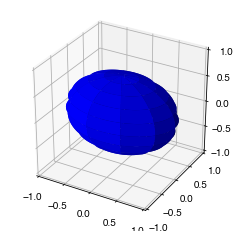

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

coefs = (1, 2, 2)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
# Radii corresponding to the coefficients:
rx, ry, rz = 1/np.sqrt(coefs)

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=10, cstride=10, color='b')

# Adjustment of the axes, so that they all have the same span:
max_radius = max(rx, ry, rz)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

plt.show()





In [1]:
import numpy as np
import open3d as o3d
input_path="/Users/baixue/Downloads/"
output_path="/Users/baixue/Downloads/"
dataname="sample.xyz"#_w_normals
point_cloud= np.loadtxt(input_path+dataname,skiprows=1)

In [2]:
point_cloud.shape

(1505010, 6)

In [3]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
#pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
#pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,6:9])

In [4]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd.normals[0]

array([ 0.57469507, -0.72857549, -0.37269739])

In [5]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

In [6]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))



In [7]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

geometry::TriangleMesh with 87791 points and 99931 triangles.

In [7]:
dec_mesh = bpa_mesh

voxel_size = max(dec_mesh.get_max_bound() - dec_mesh.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = dec_mesh.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)


voxel_size = 4.796702e-01


In [10]:
o3d.io.write_triangle_mesh(output_path+"bpa_mesh.ply", mesh_smp)


True

In [14]:
np.linalg.norm(np.asarray(pcd.normals)[0])

1.0000002444659701

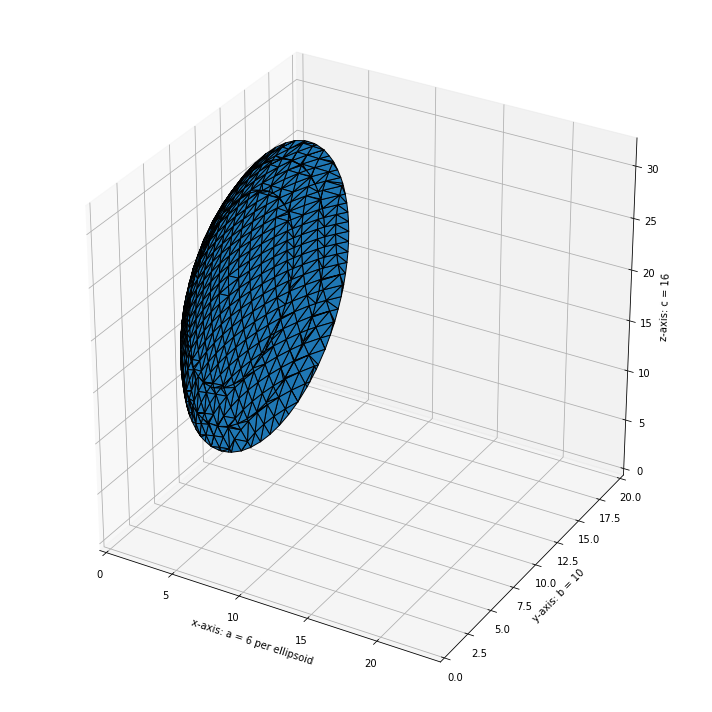

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
#ellip_double = np.concatenate((ellip_base[:-3,3:-3],
#                               ellip_base[3:,3:-3]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_base[:5], 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [14]:
verts = [(0,0,0),(0,0,0),(2,0,0),(0,2,0)]
faces = np.array([(1,2,3,4)])
with open('/Users/baixue/Downloads/test.obj', 'w') as thefile:
    for item in verts:
        thefile.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

    #for item in normals:
    #    thefile.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in faces+1:
        thefile.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  
        
    #thefile.write("l 1 2\n")  
    


In [5]:
mesh

In [46]:
apex_z = 50
verts = [(*apex,apex_z),(*wire_center,0),(*wire_bottom,0),(*wire_side,0)]


In [4]:
ellip_base.shape

(15, 23, 35)

[(12.149696844225826, 51.27839570101213, 50),
 (68.67484714407865, 60.78615705633236, 0),
 (12.149696844225826, -2.598918645802499, 0),
 (-51.92507565201865, 78.7464965898977, 0)]

2.0203215587370837

(array('d', [1.4359883345885077e-13, -8.712323530435933, -17.340742622633414, -25.80216088396076, -34.01509023107967, -41.9004356647335, -49.38225699782791, -56.38850020094561, -62.85169132203843, -68.7095862974706, -73.90577039637759, -78.39020152536372, -82.0353392737102]),
 array('d', [-66.22857142857143, -65.90966275503294, -64.95600799927682, -63.37679137792176, -61.187221610318986, -58.408385450271126, -55.06704460906579, -51.19537802556649, -46.83067196544058, -42.01496093403809, -36.79462286112689, -31.219932456076165, -25.477464671143004]))

In [46]:

class Ellipse(object):
    def __init__(self,cx,cy,a,b):
        # ellipse x axis span is 2a, y axis span is 2b
        self.center = np.array([cx,cy])
        self.a = a
        self.b = b
        
    def shape(self):
        from shapely.geometry.point import Point
        import shapely.affinity
        circ = shapely.geometry.Point(self.center).buffer(1)#circle of radius 1 around center point
        e  = shapely.affinity.scale(circ, self.a, self.b)
        return e

    def point_at_theta(self,theta):
        a,b = self.a,self.b
        from math import tan,radians,sqrt
        tan_theta = tan(radians(theta))
        x = a*b/sqrt((a*tan_theta)**2+b**2)
        if theta>90 and theta<=270:
            x = -1*x
        y = x*tan_theta
        return np.array([x,y])
    
    def length(self,theta):
        # theta is angle from major axis
        # https://math.stackexchange.com/questions/433094/how-to-determine-the-arc-length-of-ellipse
        a,b = self.a,self.b
        from math import radians,tan,atan
        import scipy
        phi = atan(a/b*tan(radians(theta)))
        m = 1-(a/b)**2
        return b*scipy.special.ellipeinc(phi,m)
    

#def draft_cup_bottom(wire,ROTATE = 3):
ROTATE = 3
ellipse = Ellipse(0,0,Horizontal/2, Vertical/2)
from scipy.optimize import minimize_scalar
def f(theta,ellipse,target):
    return abs(ellipse.length(theta)-target)
target = ellipse.length(90)-Quarter_Wire_Circumference
res = minimize_scalar(f,[45,90],args=(ellipse,target))
angle = 90-res.x


95.73601820030794 95.77000000000001
95.76997558963879 95.77000000000001


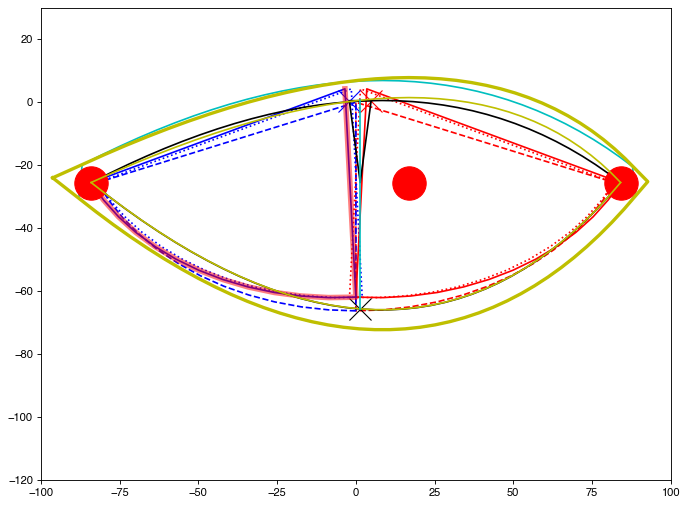

In [165]:
from shapely.geometry import LineString

       

mmtoinch = 0.0393701
W,H = 200,150
FW,FH = W*mmtoinch+2,H*mmtoinch+2
fig = plt.figure(figsize=(FW,FH),dpi=80)
ax = addax(fig,FW,FH,L=1,W=W*mmtoinch,T=0.5,H=H*mmtoinch,ncols=1,nrows=1)
ax.set(aspect=1)
ax.set(xlim=[-W/2,W/2],ylim=[30-H,30])
        
cupcenter = Pie(ellipse,270,270+angle)
cupside = Pie(ellipse,270,270-angle)
c = LineString((np.array(cupcenter.pie.exterior.coords)[:-2]))
print(c.length,Quarter_Wire_Circumference)




ax.plot(*cupcenter.pie.exterior.xy,'r--')
ax.plot(*cupside.pie.exterior.xy,'b--')

cupcenter.rotate(-ROTATE,cupcenter.get_coord(-1))
cupside.rotate(ROTATE,cupside.get_coord(-1))



ax.plot(*cupcenter.pie.exterior.xy,'r:')
ax.plot(*cupside.pie.exterior.xy,'b:')

from numpy.linalg import norm
overlap = norm(cupcenter.get_coord(0)-cupside.get_coord(0))/2
cupcenter.translate(xoff=overlap)
cupside.translate(xoff=-overlap)

ax.plot(*cupcenter.pie.exterior.xy,'r')
ax.plot(*cupside.pie.exterior.xy,'b')


def f(yratio,xratio,xrange,yrange,target):
    p2 = sliding_control_point(xrange,yrange,xratio,yratio)
    c = Bezier(np.stack((p0,p2,p1)))
    return abs(c.length()-target)
p0,p1 = cupcenter.get_coord(-1), cupside.get_coord(-1)
xrange = [p0[0],p1[0]]
yrange = [cupcenter.get_coord(1)[1], cupcenter.get_coord(0)[1]]
target = 2*Quarter_Wire_Circumference
xratio = 0.4
res = minimize_scalar(f,method='bounded', bounds=[1.1,2],args=(xratio,xrange,yrange,target))#
yratio = res.x
p2 = sliding_control_point(xrange,yrange,xratio,yratio)
wireseam = Bezier(np.stack((p0,p2,p1)))


xy = wireseam.xy()
plt.plot(xy[:,0],xy[:,1],'k-')

print(wireseam.length()/2,Quarter_Wire_Circumference)

x,y = wireseam.midpoint()
plt.plot(x,y,'kx',ms=20)

midwire = wireseam.midpoint()
apexcenter = midwire+cupcenter.get_coord(1)-cupcenter.get_coord(0)
apexside = midwire+cupside.get_coord(1)-cupside.get_coord(0)

x,y = apexcenter
plt.plot(x,y,'rx',ms=20)
x,y = apexside
plt.plot(x,y,'bx',ms=20)


##########------------------------------------------

def f(yratio,xratio,xrange,yrange,target1,target2):
    p2 = sliding_control_point(xrange,yrange,xratio,yratio)
    c = Bezier(np.stack((p0,p2,p1)))
    return LineString(c.xy()).distance(target1)+LineString(c.xy()).distance(target2)
from shapely.geometry.point import Point
xratio = 0.4
res = minimize_scalar(f,method='bounded', bounds=[-1,0],args=(xratio,xrange,yrange,Point(apexcenter),Point(apexside)))

yratio = res.x
p2 = sliding_control_point(xrange,yrange,xratio,yratio)
hseam = Bezier(np.stack((p0,p2,p1)))

xy = hseam.xy()
plt.plot(xy[:,0],xy[:,1],'k-')

from shapely.geometry import Polygon
temp = Polygon(np.vstack((apexcenter,[midwire[0],p0[1]],apexside)))
plt.plot(*temp.exterior.xy,'k-')

##########------------------------------------------
from shapely.geometry import LinearRing
seamallowance = LinearRing(np.vstack((wireseam.xy(),np.flipud(hseam.xy())))).parallel_offset(OFFSET, 'left', join_style=3)
seamallowance = LinearRing(np.stack(seamallowance.xy).T)
plt.plot(*seamallowance.xy,'c-')


#fig.savefig('shape.svg', transparent=True, rasterized=True)#            

plt.plot(*pie_side.xy,'r',lw=5,alpha=0.5)
plt.plot(*end_1,'ro',ms=30)
plt.plot(*end_2,'ro',ms=30)

l = LineString([end_1,end_2])
#_,p = LineString_point_from_edge(l,l.length*0.6)

plt.plot(*p.xy,'ro',ms=30)
plt.plot(*b.xy().T,'y')
plt.plot(*b2.xy().T,'y')
plt.plot(*np.stack([wire_bottom,apex]).T,'c',ms=30)

plt.plot(*cup_bottom_seam.T,'y',lw=3)


In [1]:
hseam.curve.evaluate_hodograph(0)


NameError: name 'hseam' is not defined

In [ ]:
def sliding_control_point(xrange,yrange,xratio,yratio):
    x = xrange[0]+xratio*(xrange[1]-xrange[0])
    y = yrange[0]+yratio*(yrange[1]-yrange[0])
    return np.array([x,y])
#def best_fit_bezier_distance_to_points():
    



<IPython.core.display.Javascript object>


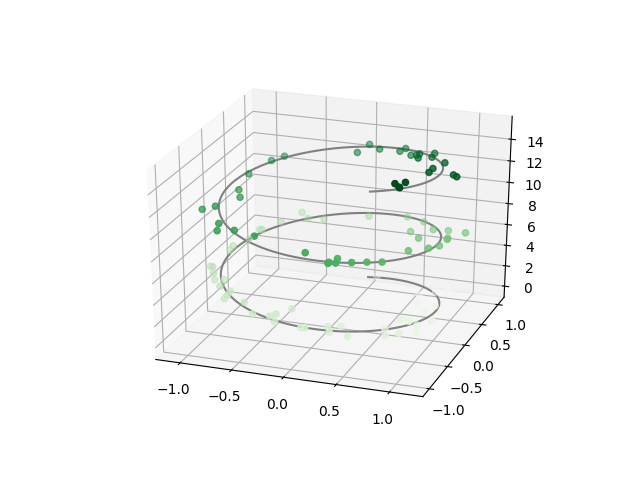

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');


In [4]:
xline.shape, zline.shape

((1000,), (1000,))